In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy.io
from scipy.stats import stats
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.svm import NuSVC
import numpy as np
import nibabel as nb  
import h5py
import brainiak.funcalign.srm

In [3]:
root_dir = '/Users/xinhui.li/Documents/HA'

# load mask
mask=nb.load(root_dir+'/mask/HCP_10k_mask.dtseries.nii').get_fdata()

# load Yeo's network mapping
L=nb.load(root_dir+'/resources/Yeo/L.Yeo2011_7Networks_N1000.10k_fs_LR.func.gii').agg_data()
R=nb.load(root_dir+'/resources/Yeo/R.Yeo2011_7Networks_N1000.10k_fs_LR.func.gii').agg_data()
yeo_network=np.concatenate((L,R))

In [9]:
sub_list = os.listdir(os.path.join(root_dir, 'data'))
subjects = len(sub_list)
data = []
for sub in sub_list:
    file = h5py.File(os.path.join(root_dir, 'data', sub, 'rfMRI_REST_RL1LR2_MSMAll_10k_filt_sm6_profile.gzipped.hdf5'),'r')
    a = file.get('__unnamed__')[()]
    b = a * mask
    b = np.transpose(b)
    data.append(b)

print("# subjects:", len(data), "\ndata shape:", data[0].shape)

# subjects: 2 
data shape: (20484, 1180)


In [10]:
corr, _ = pearsonr(data[0].flatten(), data[1].flatten())
print("anatomical alignment correlation: ", corr)

anatomical alignment correlation:  0.5594429733982812


In [47]:
# z-score
# for subject in range(subjects):
#     data[subject] = stats.zscore(data[subject],axis=0,ddof=1) # NaN if along target axis

Run SRM 

In [11]:
srm = brainiak.funcalign.srm.SRM(n_iter=10, features=50)
srm.fit(data)
basis = srm.w_
shared_response = srm.s_
print("W shape: ", basis[0].shape, "\nS shape: ", shared_response.shape)

W shape:  (20484, 50) 
S shape:  (50, 1180)


In [14]:
shared_data = []
for sub in range(subjects):
    shared_data.append(np.dot(basis[sub],shared_response)) 

corr, _ = pearsonr(shared_data[0].flatten(), shared_data[1].flatten())
print("Shared features correlation: ", corr)

Shared features correlation:  0.7885397249064482


In [15]:
U, sigma, V = np.linalg.svd(np.dot(data[0], shared_response.T))

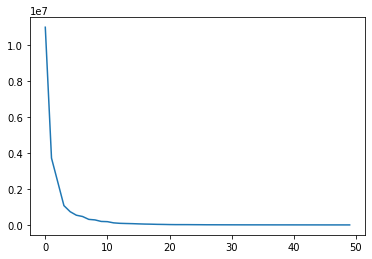

In [16]:
plt.plot(range(0,50), sigma)
plt.savefig("/Users/xinhui.li/Documents/SRMC/figs/sigma.png")

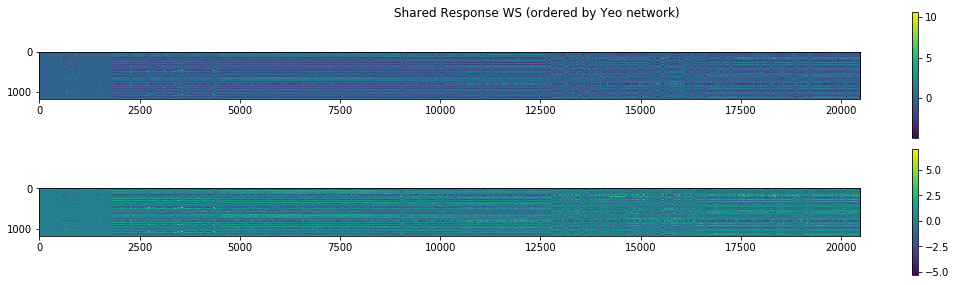

In [24]:
fig, axs = plt.subplots(subjects, figsize=(15,4))
fig.suptitle("Shared Response WS (ordered by Yeo network)")
for i in range(subjects):
    im = axs[i].imshow(shared_data[i][np.argsort(yeo_network),:].T)
    fig.colorbar(im, ax=axs[i])
fig.tight_layout()
plt.savefig("/Users/xinhui.li/Documents/SRMC/figs/shared_response.png")

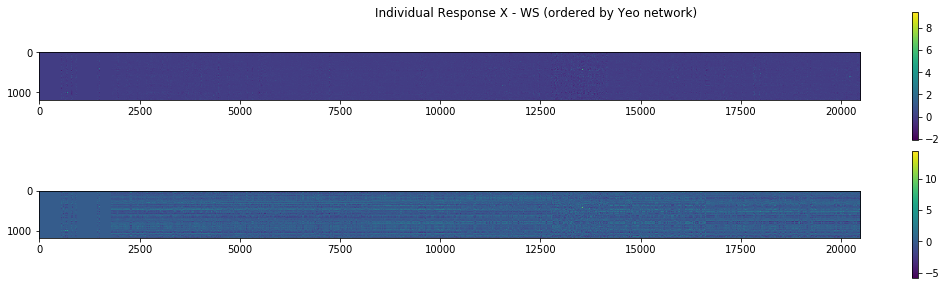

In [25]:
fig, axs = plt.subplots(subjects, figsize=(15,4))
fig.suptitle("Individual Response X - WS (ordered by Yeo network)")
for i in range(subjects):
    err = data[i] - shared_data[i]
    im = axs[i].imshow(err[np.argsort(yeo_network),:].T)
    fig.colorbar(im, ax=axs[i])
fig.tight_layout()
plt.savefig("/Users/xinhui.li/Documents/SRMC/figs/individual_response.png")